In [1]:
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.regularization import *
from lasagne.random import get_rng
from lasagne.updates import *
from lasagne.init import *
import numpy as np
import sys
sys.path.append("../../modules/")
import helper as hp

from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

import matplotlib.pyplot as plt
%matplotlib inline

//anaconda/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [8]:
def negative_relu(x):
    return T.minimum(0, x)

In [153]:
sys.stderr.write("loading mnist...\n")
train_data, valid_data, _ = hp.load_mnist("../../data/mnist.pkl.gz")
X_train, y_train = train_data
X_valid, y_valid = valid_data
# minimal
X_train = X_train[0:5000].astype("float32")
y_train = y_train[0:5000].astype("int32")

loading mnist...


In [143]:
def get_net(args):
    l_in = InputLayer( (None, 1, 28, 28) )
    l_conv1 = Conv2DLayer(l_in, num_filters=8, filter_size=3, nonlinearity=linear)
    if args["relu_layer"]:
        l_conv1 = ReluLayer(l_conv1)
    else:
        l_conv1 = NonlinearityLayer(l_conv1, nonlinearity=rectify)
    l_mp1 = MaxPool2DLayer(l_conv1, pool_size=2)
    l_conv2 = Conv2DLayer(l_mp1, num_filters=16, filter_size=3, nonlinearity=linear)
    if args["relu_layer"]:
        l_conv2 = ReluLayer(l_conv2)
    else:
        l_conv2 = NonlinearityLayer(l_conv2, nonlinearity=rectify)
    l_mp2 = MaxPool2DLayer(l_conv2, pool_size=2)
    l_conv3 = Conv2DLayer(l_mp2, num_filters=32, filter_size=3, nonlinearity=linear)
    if args["relu_layer"]:
        l_conv3 = ReluLayer(l_conv3)
    else:
        l_conv3 = NonlinearityLayer(l_conv3, nonlinearity=rectify)
    l_pen = DenseLayer(l_conv3, num_units=64, nonlinearity=linear)
    if args["relu_layer"]:
        l_pen = ReluLayer(l_pen)
    else:
        l_pen = NonlinearityLayer(l_pen, nonlinearity=rectify)
    l_dense = DenseLayer(l_pen, num_units=10, nonlinearity=softmax)
    for layer in get_all_layers(l_dense):
        print layer, layer.output_shape
    print count_params(l_dense)
    return l_dense

In [129]:
l_out = get_net()

<lasagne.layers.input.InputLayer object at 0x10dc65590> (None, 1, 28, 28)
<lasagne.layers.conv.Conv2DLayer object at 0x10dc656d0> (None, 8, 26, 26)
<__main__.ReluLayer object at 0x10dc65cd0> (None, 8, 26, 26)
<lasagne.layers.pool.MaxPool2DLayer object at 0x10dc65a10> (None, 8, 13, 13)
<lasagne.layers.conv.Conv2DLayer object at 0x10dc65a90> (None, 16, 11, 11)
<__main__.ReluLayer object at 0x10dc655d0> (None, 16, 11, 11)
<lasagne.layers.pool.MaxPool2DLayer object at 0x10dc65b50> (None, 16, 5, 5)
<lasagne.layers.conv.Conv2DLayer object at 0x10dc65c50> (None, 32, 3, 3)
<__main__.ReluLayer object at 0x10dc65790> (None, 32, 3, 3)
<lasagne.layers.dense.DenseLayer object at 0x10dc65290> (None, 64)
<__main__.ReluLayer object at 0x10dc65950> (None, 64)
<lasagne.layers.dense.DenseLayer object at 0x10dc5ae10> (None, 10)
25034


In [98]:
class ReluLayer(Layer):
    def __init__(self, incoming, p=0.5, **kwargs):
        super(ReluLayer, self).__init__(incoming, **kwargs)
        self._srng = RandomStreams(get_rng().randint(1, 2147462579))
        self.incoming = incoming
        self.p = p
        #self.mask = theano.shared(
        #    self._srng.binomial(n=1, p=(self.p), size=incoming.output_shape[1::]))
        self.mask = np.random.binomial(n=1, p=self.p, size=incoming.output_shape[1::])
    def get_output_for(self, input, deterministic=False, **kwargs):
        return self.mask*rectify(input) + (1-self.mask)*negative_relu(input)

In [107]:
l_in = InputLayer( (None, 1, 3, 3) )
l_r = ReluLayer(l_in)

In [141]:
def train(X_train, y_train, args={}):
    # config
    X = T.tensor4('X')
    y = T.ivector('y')
    l_out = get_net(args)
    net_out = get_output(l_out, X)
    loss = categorical_crossentropy(net_out, y).mean()
    params = get_all_params(l_out, trainable=True)
    updates = nesterov_momentum(loss, params, learning_rate=0.01, momentum=0.9)
    train_fn = theano.function([X, y], loss, updates=updates)    
    # training
    bs = 32
    n_batches = X_train.shape[0] // bs
    num_epochs=10
    epochs = []
    losses = []
    for epoch in range(0, num_epochs):
        idxs = [x for x in range(0, X_train.shape[0])]
        np.random.shuffle(idxs)
        X_train = X_train[idxs]
        y_train = y_train[idxs]
        train_losses=[]
        for b in range(0, n_batches):
            X_batch, y_batch = X_train[b*bs:(b+1)*bs], y_train[b*bs:(b+1)*bs]
            train_losses.append(train_fn(X_batch,y_batch))
        epochs.append(epoch+1)
        losses.append(np.mean(train_losses))
    return (epochs, losses)

In [154]:
exp1 = train(X_train, y_train, {"relu_layer":True})
exp2 = train(X_train, y_train, {"relu_layer":True})
exp3 = train(X_train, y_train, {"relu_layer":True})

<lasagne.layers.input.InputLayer object at 0x115d7ced0> (None, 1, 28, 28)
<lasagne.layers.conv.Conv2DLayer object at 0x115d7cad0> (None, 8, 26, 26)
<__main__.ReluLayer object at 0x115d7e250> (None, 8, 26, 26)
<lasagne.layers.pool.MaxPool2DLayer object at 0x115d48a90> (None, 8, 13, 13)
<lasagne.layers.conv.Conv2DLayer object at 0x115d48110> (None, 16, 11, 11)
<__main__.ReluLayer object at 0x115d48b10> (None, 16, 11, 11)
<lasagne.layers.pool.MaxPool2DLayer object at 0x115d7c950> (None, 16, 5, 5)
<lasagne.layers.conv.Conv2DLayer object at 0x115d7c210> (None, 32, 3, 3)
<__main__.ReluLayer object at 0x115d48310> (None, 32, 3, 3)
<lasagne.layers.dense.DenseLayer object at 0x10df543d0> (None, 64)
<__main__.ReluLayer object at 0x10f257ed0> (None, 64)
<lasagne.layers.dense.DenseLayer object at 0x10f257290> (None, 10)
25034
<lasagne.layers.input.InputLayer object at 0x117e35f90> (None, 1, 28, 28)
<lasagne.layers.conv.Conv2DLayer object at 0x115a58c90> (None, 8, 26, 26)
<__main__.ReluLayer object

In [155]:
exp1b = train(X_train, y_train, {"relu_layer":False})
exp2b = train(X_train, y_train, {"relu_layer":False})
exp3b = train(X_train, y_train, {"relu_layer":False})

<lasagne.layers.input.InputLayer object at 0x1171f7b10> (None, 1, 28, 28)
<lasagne.layers.conv.Conv2DLayer object at 0x1171f7290> (None, 8, 26, 26)
<lasagne.layers.special.NonlinearityLayer object at 0x117b01310> (None, 8, 26, 26)
<lasagne.layers.pool.MaxPool2DLayer object at 0x1171f7ed0> (None, 8, 13, 13)
<lasagne.layers.conv.Conv2DLayer object at 0x1171f7210> (None, 16, 11, 11)
<lasagne.layers.special.NonlinearityLayer object at 0x1171f7f10> (None, 16, 11, 11)
<lasagne.layers.pool.MaxPool2DLayer object at 0x1171f7850> (None, 16, 5, 5)
<lasagne.layers.conv.Conv2DLayer object at 0x1171f7950> (None, 32, 3, 3)
<lasagne.layers.special.NonlinearityLayer object at 0x1171f7610> (None, 32, 3, 3)
<lasagne.layers.dense.DenseLayer object at 0x10e639f10> (None, 64)
<lasagne.layers.special.NonlinearityLayer object at 0x1171f7550> (None, 64)
<lasagne.layers.dense.DenseLayer object at 0x117445a10> (None, 10)
25034
<lasagne.layers.input.InputLayer object at 0x115a62210> (None, 1, 28, 28)
<lasagne.lay

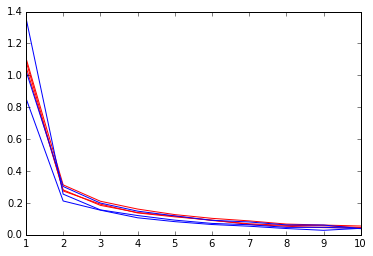

In [156]:
plt.plot(
    exp1[0], exp1[1], "r-", 
    exp2[0], exp2[1], "r-", 
    exp3[0], exp3[1], "r-",
    exp1b[0], exp1b[1], "b-",
    exp2b[0], exp2b[1], "b-",
    exp3b[0], exp3b[1], "b-"

)

In [162]:
get_net({"relu_layer":True}).input_layer.input_layer.input_layer.mask

<lasagne.layers.input.InputLayer object at 0x117d7b890> (None, 1, 28, 28)
<lasagne.layers.conv.Conv2DLayer object at 0x117fbc950> (None, 8, 26, 26)
<__main__.ReluLayer object at 0x10ed36b90> (None, 8, 26, 26)
<lasagne.layers.pool.MaxPool2DLayer object at 0x117895610> (None, 8, 13, 13)
<lasagne.layers.conv.Conv2DLayer object at 0x117895f50> (None, 16, 11, 11)
<__main__.ReluLayer object at 0x117895a90> (None, 16, 11, 11)
<lasagne.layers.pool.MaxPool2DLayer object at 0x117dee710> (None, 16, 5, 5)
<lasagne.layers.conv.Conv2DLayer object at 0x117deebd0> (None, 32, 3, 3)
<__main__.ReluLayer object at 0x117dee9d0> (None, 32, 3, 3)
<lasagne.layers.dense.DenseLayer object at 0x115a01810> (None, 64)
<__main__.ReluLayer object at 0x115a01a10> (None, 64)
<lasagne.layers.dense.DenseLayer object at 0x115a01750> (None, 10)
25034


array([[[0, 1, 0],
        [1, 0, 0],
        [0, 1, 1]],

       [[0, 0, 1],
        [0, 1, 0],
        [0, 0, 0]],

       [[1, 0, 0],
        [0, 1, 1],
        [0, 1, 0]],

       [[1, 1, 1],
        [0, 1, 0],
        [1, 0, 1]],

       [[0, 1, 0],
        [0, 1, 0],
        [1, 1, 0]],

       [[0, 1, 1],
        [1, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 1, 1],
        [1, 1, 1]],

       [[1, 1, 0],
        [0, 1, 0],
        [1, 0, 0]],

       [[1, 1, 0],
        [1, 0, 1],
        [0, 1, 1]],

       [[1, 0, 0],
        [0, 0, 1],
        [0, 0, 1]],

       [[1, 0, 0],
        [1, 1, 1],
        [0, 0, 0]],

       [[1, 1, 1],
        [0, 0, 1],
        [1, 1, 1]],

       [[1, 0, 1],
        [0, 1, 1],
        [0, 0, 1]],

       [[0, 0, 1],
        [1, 1, 0],
        [1, 1, 1]],

       [[0, 1, 1],
        [1, 0, 0],
        [1, 1, 0]],

       [[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0]],

       [[0, 1, 1],
        [1, 1, 0],
        [1, 1, 1]]